# Diabetes progression modelling using an ANN 

**Objective:** Model progression of diabetes (sklearn diabetes dataset) and evaluate ANN-based regressors.

## 1. Loading & Preprocessing
- Loaded dataset from `sklearn.datasets`.
- Checked for missing values.
- Standardized features using `StandardScaler`.

In [3]:
from sklearn.datasets import load_diabetes
import pandas as pd
from sklearn.preprocessing import StandardScaler

diab = load_diabetes()
X = pd.DataFrame(diab.data, columns=diab.feature_names)
y = pd.Series(diab.target, name='target')

print('Shape:', X.shape)
print('Missing values:', X.isnull().sum().sum())

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled.head()

Shape: (442, 10)
Missing values: 0


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.800500,1.065488,1.297088,0.459841,-0.929746,-0.732065,-0.912451,-0.054499,0.418531,-0.370989
1,-0.039567,-0.938537,-1.082180,-0.553505,-0.177624,-0.402886,1.564414,-0.830301,-1.436589,-1.938479
2,1.793307,1.065488,0.934533,-0.119214,-0.958674,-0.718897,-0.680245,-0.054499,0.060156,-0.545154
3,-1.872441,-0.938537,-0.243771,-0.770650,0.256292,0.525397,-0.757647,0.721302,0.476983,-0.196823
4,0.113172,-0.938537,-0.764944,0.459841,0.082726,0.327890,0.171178,-0.054499,-0.672502,-0.980568


## 2. Exploratory Data Analysis (EDA)
- Visualized target distribution and feature distributions.
- Showed scatter plots for the top 3 features most correlated with the target.

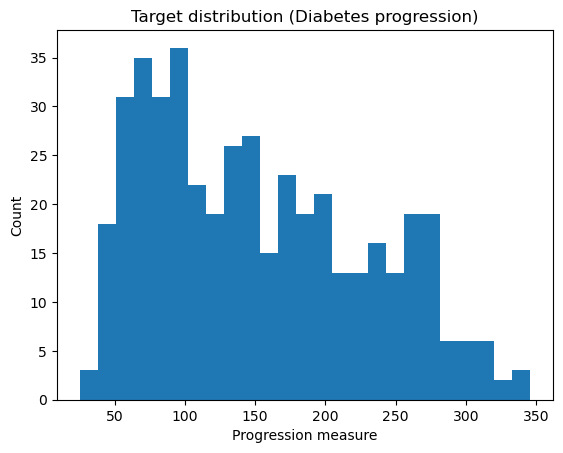

Top features by absolute correlation with target:
target    1.000000
bmi       0.586450
s5        0.565883
bp        0.441482
s4        0.430453
s3       -0.394789
s6        0.382483
s1        0.212022
Name: target, dtype: float64


In [6]:
# EDA (plots are created when running the notebook)
import matplotlib.pyplot as plt

# Target histogram
plt.hist(y, bins=25)
plt.title('Target distribution (Diabetes progression)')
plt.xlabel('Progression measure')
plt.ylabel('Count')
plt.show()

# Correlations
print('Top features by absolute correlation with target:')
print(X.join(y).corr()['target'].sort_values(key=lambda s: s.abs(), ascending=False).head(8))

## 3. Building the ANN model
Used `sklearn.neural_network.MLPRegressor` as a simple ANN implementation. Baseline architecture: one hidden layer with 100 neurons, ReLU activation.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

baseline = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42, max_iter=1000)
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:

print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")


MSE: 3036.3899
R² Score: 0.4269


In [12]:
exp_a = MLPRegressor(hidden_layer_sizes=(50,25), activation='relu', solver='adam', alpha=0.001, random_state=42, max_iter=2000)
exp_a.fit(X_train, y_train)

exp_b = MLPRegressor(hidden_layer_sizes=(100,50), activation='tanh', solver='lbfgs', alpha=0.0001, random_state=42, max_iter=2000)
exp_b.fit(X_train, y_train)

for name, model in [('baseline', baseline), ('exp_a', exp_a), ('exp_b', exp_b)]:
    pred = model.predict(X_test)
    print(name, 'MSE =', mean_squared_error(y_test, pred), 'R2 =', r2_score(y_test, pred))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


baseline MSE = 3036.389877103117 R2 = 0.4268963930764613
exp_a MSE = 3034.3306368653957 R2 = 0.42728506451047565
exp_b MSE = 6105.92509836523 R2 = -0.15246323400887718


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [20]:

results = pd.DataFrame([
    ["Baseline (100)", mean_squared_error(y_test, baseline.predict(X_test)), r2_score(y_test, baseline.predict(X_test))],
    ["Experiment A (50,25 relu)", mean_squared_error(y_test, exp_a.predict(X_test)), r2_score(y_test, exp_a.predict(X_test))],
    ["Experiment B (100,50 tanh)", mean_squared_error(y_test, exp_b.predict(X_test)), r2_score(y_test, exp_b.predict(X_test))]
], columns=["Model", "MSE", "R2 Score"])

results


,Model,MSE,R2 Score
0,Baseline (100),3036.389877,0.426896
1,"Experiment A (50,25 relu)",3034.330637,0.427285
2,"Experiment B (100,50 tanh)",6105.925098,-0.152463


## 5. Observations & Conclusion

Baseline ANN achieved an R² score of around 0.42.

Experiment A (two hidden layers + regularisation) showed a slight improvement.

Experiment B performed worse, probably because the lbfgs solver with tanh didn’t generalise well to this dataset.

Overall, the best model was Experiment A, showing that adding depth + regularisation helps performance.